In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-jan-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-jan-2022/train.csv
/kaggle/input/tabular-playground-series-jan-2022/test.csv


In [2]:
import gc
import random

from IPython import display as ipd
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler, RobustScaler, LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold,GroupKFold

from sklearn.metrics import mean_absolute_error, mean_squared_error, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.layers import InputLayer, SpatialDropout1D
from tensorflow.keras.layers import add, concatenate, GlobalMaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, Activation, Conv1D, Flatten, MaxPooling1D
from tensorflow.keras.layers import Multiply, Add, Concatenate, Flatten, Average, Lambda
from tensorflow.keras.layers import Conv2D, MaxPool2D

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, Callback, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras import backend as K
from tensorflow_addons.optimizers import CyclicalLearningRate

### Utils

In [3]:
def seeding(SEED, use_tf=False):
    np.random.seed(SEED)
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    os.environ['TF_CUDNN_DETERMINISTIC'] = str(SEED)
    if use_tf:
        tf.random.set_seed(SEED)
    print('seeding done!!!')
    
## https://www.kaggle.com/c/tabular-playground-series-jan-2022/discussion/298201
def SMAPE(y_true, y_pred):
    denominator = (y_true + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.mean(diff)    

### Data Load

In [4]:
RANDOM_SEED = 42
DEBUG = True

seeding(RANDOM_SEED)

train = pd.read_csv('/kaggle/input/tabular-playground-series-jan-2022/train.csv')
test = pd.read_csv('/kaggle/input/tabular-playground-series-jan-2022/test.csv')
submission = pd.read_csv('/kaggle/input/tabular-playground-series-jan-2022/sample_submission.csv')

seeding done!!!


In [5]:
train.head()

,row_id,date,country,store,product,num_sold
0,0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329
1,1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520
2,2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146
3,3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572
4,4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911


## Targets distribution display

Text(0.5, 1.0, 'Sweden')

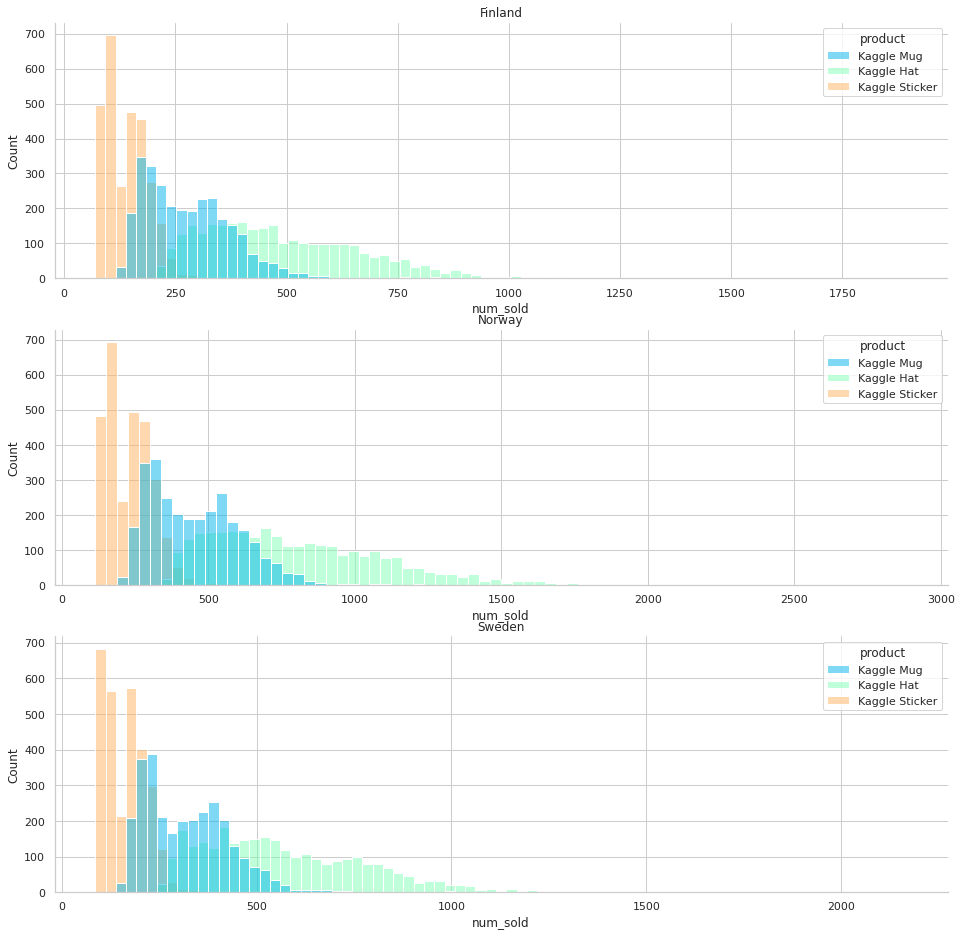

In [6]:
## targets distribution by country

f, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(16, 16))
sns.despine(f)
g1 = sns.histplot( data=train[train['country'] == 'Finland'], x = 'num_sold', hue='product', ax=ax1,  palette="rainbow")
g1.set_title("Finland")
g2 = sns.histplot( data=train[train['country'] == 'Norway'], x = 'num_sold', hue='product', ax=ax2,  palette="rainbow")
g2.set_title("Norway")
g3 = sns.histplot( data=train[train['country'] == 'Sweden'], x = 'num_sold', hue='product', ax=ax3,  palette="rainbow")
g3.set_title("Sweden")

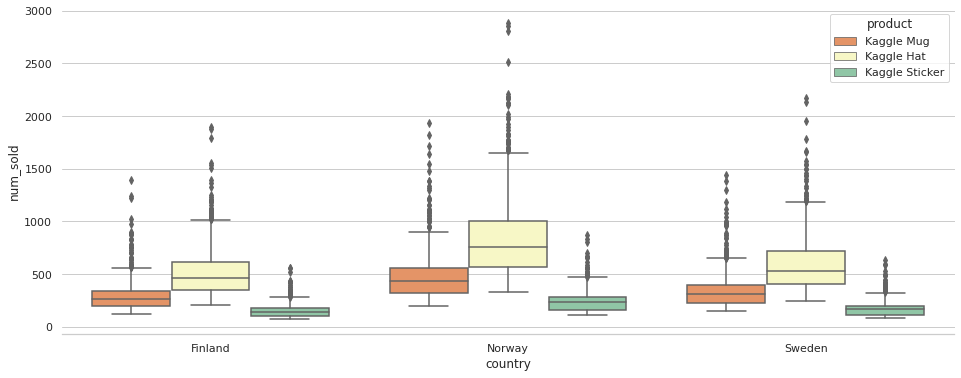

In [7]:
f, ax1 = plt.subplots(1, 1, figsize=(16, 6))

sns.boxplot( data=train, x="country", y="num_sold", hue="product", ax=ax1, palette="Spectral")
sns.despine(left=True)

<AxesSubplot:xlabel='product', ylabel='num_sold'>

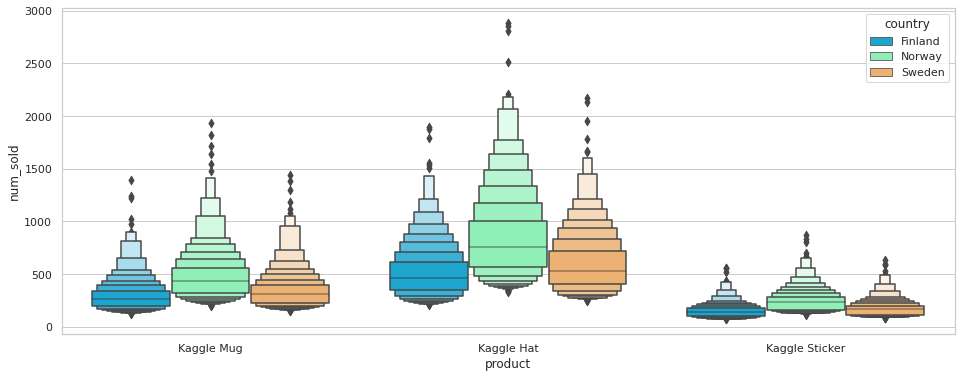

In [8]:
## Another nice way of showing distribution

f, ax1 = plt.subplots(1, 1, figsize=(16, 6))
product_order = ["Kaggle Mug", "Kaggle Hat", "Kaggle Sticker"]
sns.boxenplot(x="product", y="num_sold", palette="rainbow", hue='country', order=product_order, scale="linear", data=train)

### Very simple date-based FE

In [9]:
def process_dates(df):
    df.date = pd.to_datetime(df.date)
    df['year'] = df.date.dt.year    
    df['month'] = df.date.dt.month
    df['week'] = df.date.dt.week
    df['dayofweek'] = df.date.dt.dayofweek
    df['dayofyear'] = df.date.dt.dayofyear
    df['day'] = df.date.dt.day
    return df

train = process_dates(train)
test = process_dates(test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """


In [10]:
print(f'Train unique days: {train.day.unique().size}, test: {test.day.unique().size}')
print(f'Train unique weeks: {train.week.unique().size}, test: {test.week.unique().size}')
print(f'Train unique dayofweeks: {train.dayofweek.unique().size}, test: {train.dayofweek.unique().size}')
print(f'Train unique months: {train.month.unique().size}, test: {train.month.unique().size}')
print(f'Train unique dayofyear: {train.dayofyear.unique().size}, test: {train.dayofyear.unique().size}')

Train unique days: 31, test: 31
Train unique weeks: 53, test: 52
Train unique dayofweeks: 7, test: 7
Train unique months: 12, test: 12
Train unique dayofyear: 366, test: 366


In [11]:
target = train.num_sold
train.drop(['row_id','num_sold','date'], axis=1, inplace=True)
test.drop(['row_id', 'date'], axis=1, inplace=True)

### Encode category columns 

In [12]:
country_encoder = LabelEncoder()
train['country_enc'] = country_encoder.fit_transform(train['country'])
test['country_enc'] = country_encoder.transform(test['country'])

store_encoder = LabelEncoder()
train['store_enc'] = store_encoder.fit_transform(train['store'])
test['store_enc'] = store_encoder.transform(test['store'])

product_encoder = LabelEncoder()
train['product_enc'] = product_encoder.fit_transform(train['product'])
test['product_enc'] = product_encoder.transform(test['product'])

groups = train.year
train.drop(['country','store','product'], axis=1, inplace=True)
test.drop(['country','store','product'], axis=1, inplace=True)

In [13]:
for col in train.columns:
    train[col] = pd.Categorical(train[col])
for col in test.columns:
    test[col] = pd.Categorical(test[col])

### Model and train

In [14]:
def create_model(units, dim, optimizer):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.Input(shape=(dim,)))
    model.add(tf.keras.layers.Dense(units = units*4, activation = 'relu'))
    #model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(units = units*2, activation = 'relu'))
    #model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(units = units, activation = 'relu'))
    #model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(units = 1, activation = 'linear'))
    model.compile(optimizer = optimizer, loss = 'mean_absolute_error')
    return model    

In [15]:
UNITS = 32
EPOCHS = 200
BATCH_SIZE = 1024
TOTAL_SPLITS = 5
LEARNING_RATE = 0.005

m = create_model(UNITS, train.shape[1], Adam(learning_rate=LEARNING_RATE))
m.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1280      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 11,649
Trainable params: 11,649
Non-trainable params: 0
_________________________________________________________________



User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

In [16]:
#scaler = RobustScaler()
#train_scaled = scaler.fit_transform(train)
#test_scaled = scaler.transform(test)

In [17]:
lr = ReduceLROnPlateau(monitor="val_loss", factor=0.7, patience=20, verbose=1)
es = EarlyStopping(monitor="val_loss", patience=60, verbose=1, mode="min", restore_best_weights=True)

scores = []
models = []
histories = []
folds = StratifiedKFold(n_splits=TOTAL_SPLITS, shuffle=True, random_state=RANDOM_SEED)
for fold_n, (train_index, valid_index) in enumerate(folds.split(train, target)):
    print('-'*15, '>', f'Fold {fold_n+1}', '<', '-'*15)
    X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
    y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]    
    
    checkpoint_path = f'model_{fold_n}.h5'
    checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True)
    
    model = create_model(UNITS, train.shape[1], Adam(learning_rate=LEARNING_RATE))
    history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size = BATCH_SIZE, epochs = EPOCHS, 
                    verbose=1, shuffle=True, callbacks=[lr, checkpoint])
    
    model.load_weights(checkpoint_path)
    
    oof_pred = model.predict(X_valid).reshape(-1)
    score = SMAPE(y_valid, oof_pred)
    print(f'OOF SMAPE: {score}')
    
    scores.append(score)
    models.append(model)
    histories.append(history)

--------------- > Fold 1 < ---------------


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
2022-01-06 00:11:58.665506: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200
21/21 [==============================] - 1s 14ms/step - loss: 233.4097 - val_loss: 191.8548
Epoch 2/200
21/21 [==============================] - 0s 6ms/step - loss: 192.2226 - val_loss: 191.6705
Epoch 3/200
21/21 [==============================] - 0s 6ms/step - loss: 192.4126 - val_loss: 192.2046
Epoch 4/200
21/21 [==============================] - 0s 6ms/step - loss: 191.7843 - val_loss: 191.0522
Epoch 5/200
21/21 [==============================] - 0s 6ms/step - loss: 191.8708 - val_loss: 190.8779
Epoch 6/200
21/21 [==============================] - 0s 6ms/step - loss: 191.4076 - val_loss: 190.6100
Epoch 7/200
21/21 [==============================] - 0s 6ms/step - loss: 191.0686 - val_loss: 190.6783
Epoch 8/200
21/21 [==============================] - 0s 6ms/step - loss: 190.6601 - val_loss: 189.4748
Epoch 9/200
21/21 [==============================] - 0s 6ms/step - loss: 190.0365 - val_loss: 189.1934
Epoch 10/200
21/21 [==============================] - 0s 5ms/step - loss

In [18]:
print(f'OOF SMAPE: { np.mean(scores)}')

OOF SMAPE: 19.81919444786022


### Plot metrics

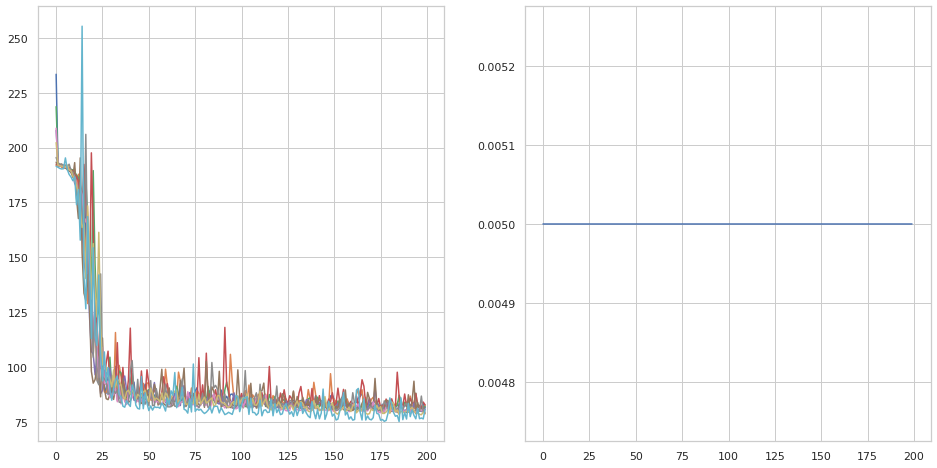

In [19]:
xx = range(0, EPOCHS)
col_metrics = ["loss", "val_loss", "lr"]

f, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(16, 8))
for hist in histories:
    df = pd.DataFrame(hist.history, columns=col_metrics)
    ax1.plot( df[[col_metrics[0], col_metrics[1]]])
ax2.plot( df[[col_metrics[2]]])

plt.show()

In [20]:
y_pred = np.zeros( (len(models), len(test)))

idx = 0
for model in models:
    y_pred[idx] = model.predict(test).reshape(-1)
    idx += 1    
    
y_pred = np.mean(y_pred, axis=0)    

### Submission

In [21]:
submission['num_sold'] = np.round(y_pred).astype(int)
submission.to_csv('submission.csv', index=False, float_format='%.6f')
submission.head(20)

,row_id,num_sold
0,26298,266
1,26299,500
2,26300,136
3,26301,451
4,26302,789
5,26303,232
6,26304,286
7,26305,525
8,26306,146
9,26307,476


### Compare predicted with train 

In [22]:
train = pd.read_csv('/kaggle/input/tabular-playground-series-jan-2022/train.csv')
test = pd.read_csv('/kaggle/input/tabular-playground-series-jan-2022/test.csv')
test['num_sold'] = 0
test['num_sold'] = np.round(y_pred).astype(int)

(-20.0, 2000.0)

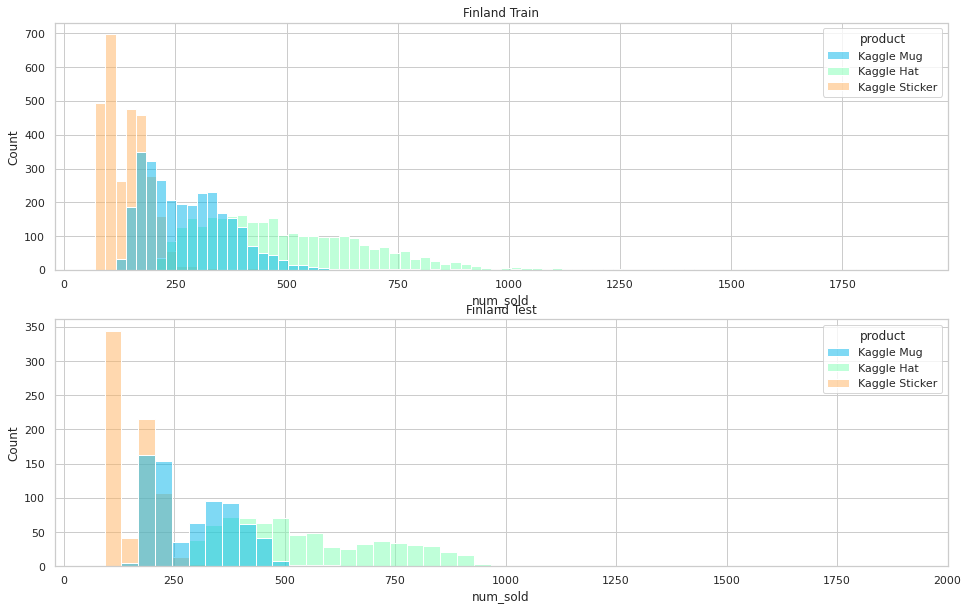

In [23]:
f, (ax1,ax2) = plt.subplots(2, 1, figsize=(16, 10))

g1 = sns.histplot( data=train[train['country'] == 'Finland'], x = 'num_sold', hue='product', ax=ax1,  palette="rainbow")
g1.set_title("Finland Train")

g2 = sns.histplot( data=test[test['country'] == 'Finland'], x = 'num_sold', hue='product', ax=ax2,  palette="rainbow")
g2.set_title("Finland Test")
plt.xlim(-20, 2000) 

(-20.0, 3000.0)

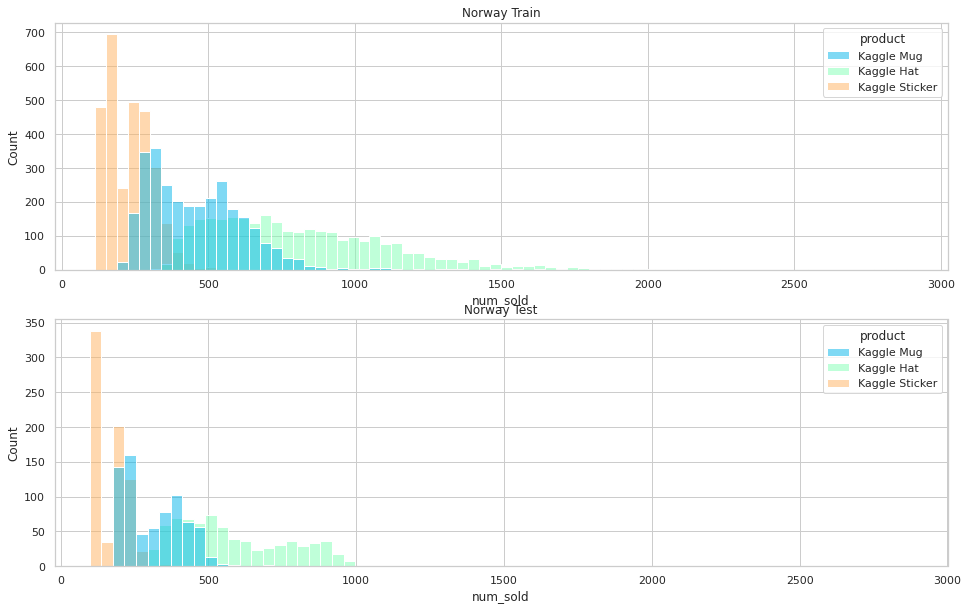

In [24]:
f, (ax1,ax2) = plt.subplots(2, 1, figsize=(16, 10))

g1 = sns.histplot( data=train[train['country'] == 'Norway'], x = 'num_sold', hue='product', ax=ax1,  palette="rainbow")
g1.set_title("Norway Train")

g2 = sns.histplot( data=test[test['country'] == 'Norway'], x = 'num_sold', hue='product', ax=ax2,  palette="rainbow")
g2.set_title("Norway Test")
plt.xlim(-20, 3000) 

<AxesSubplot:xlabel='product', ylabel='num_sold'>

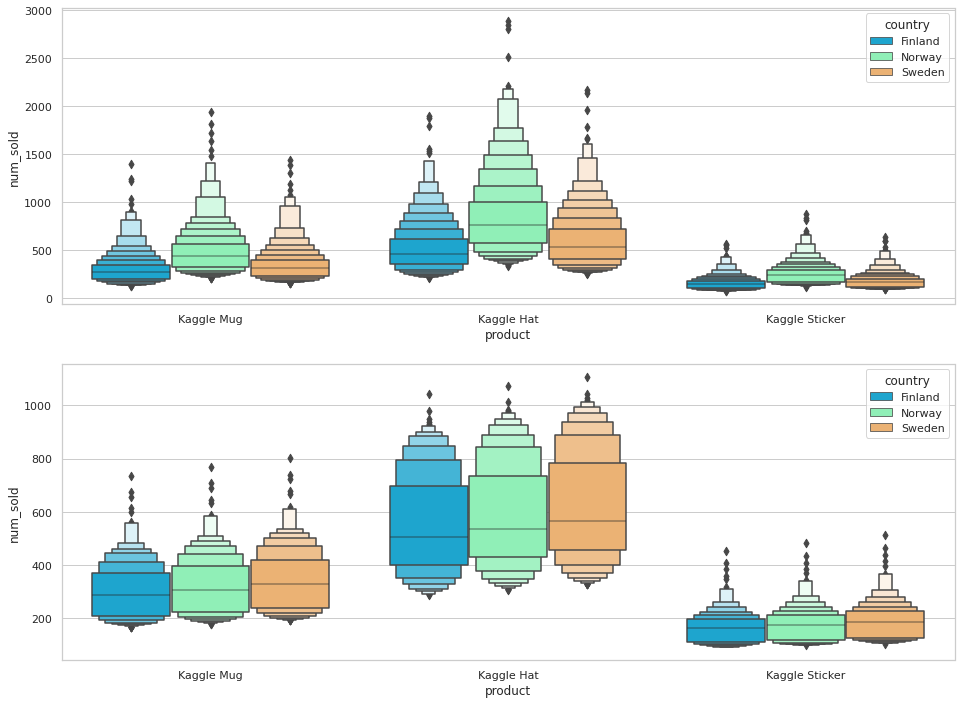

In [25]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))
product_order = ["Kaggle Mug", "Kaggle Hat", "Kaggle Sticker"]
sns.boxenplot(x="product", y="num_sold", palette="rainbow", hue='country', order=product_order, scale="linear", data=train, ax=ax1)
sns.boxenplot(x="product", y="num_sold", palette="rainbow", hue='country', order=product_order, scale="linear", data=test, ax=ax2)

## Display predicted compared to train data

In [26]:
train.date = pd.to_datetime(train.date)
test.date = pd.to_datetime(test.date)

### Sales by year and country

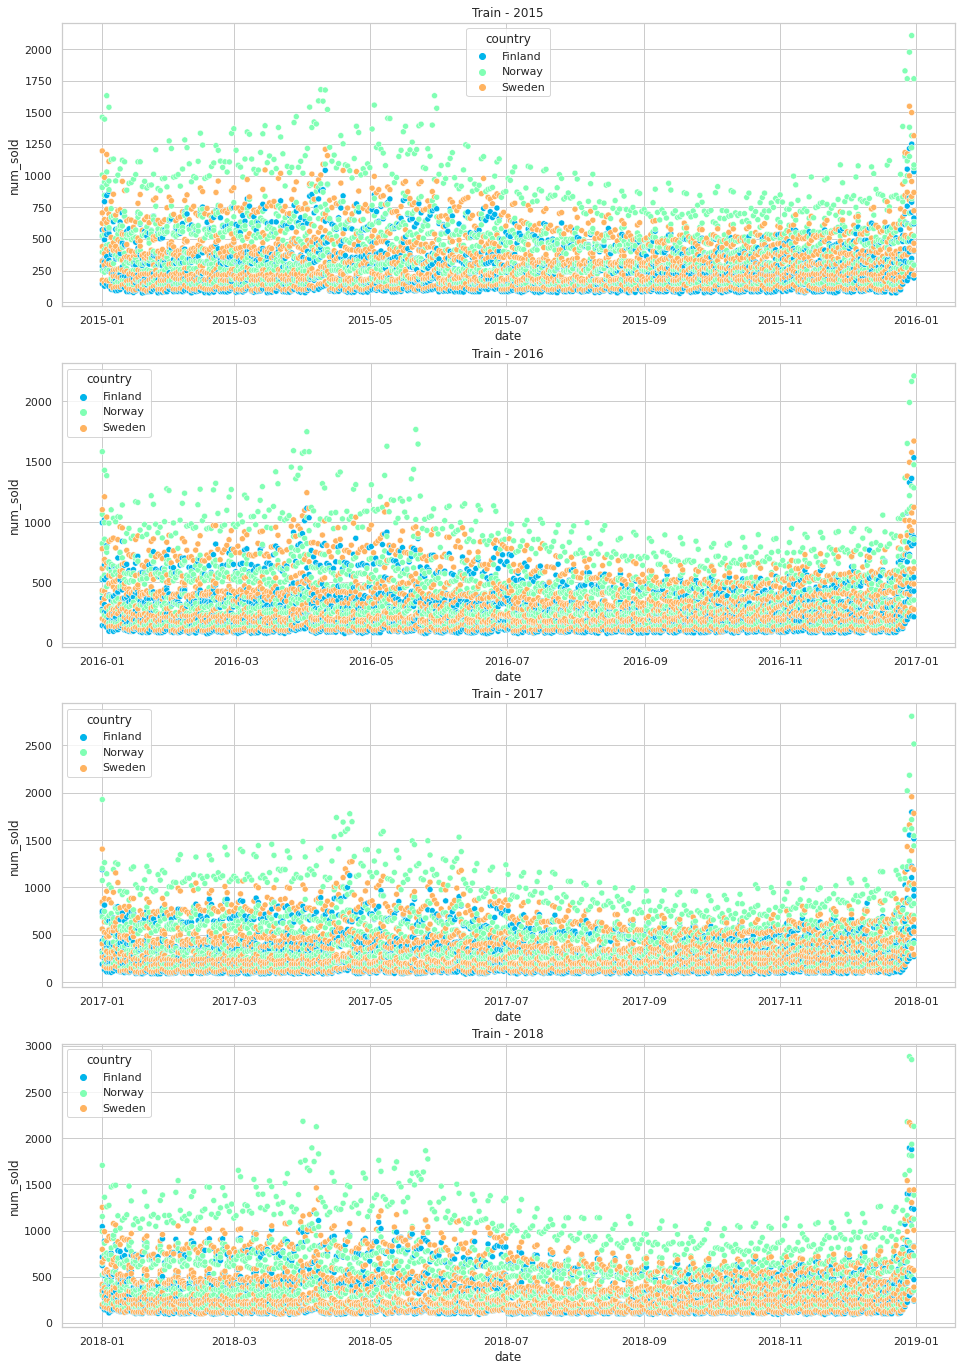

In [27]:
f, (ax1, ax2, ax3,ax4) = plt.subplots(4, 1, figsize=(16, 24))

g1 = sns.scatterplot(x="date", y="num_sold", palette="rainbow", hue='country', data=train[train.date.dt.year==2015], ax=ax1)
g1.set_title("Train - 2015")

g2 = sns.scatterplot(x="date", y="num_sold", palette="rainbow", hue='country', data=train[train.date.dt.year==2016], ax=ax2)
g2.set_title("Train - 2016")

g3 = sns.scatterplot(x="date", y="num_sold", palette="rainbow", hue='country', data=train[train.date.dt.year==2017], ax=ax3)
g3.set_title("Train - 2017")

g4 = sns.scatterplot(x="date", y="num_sold", palette="rainbow", hue='country', data=train[train.date.dt.year==2018], ax=ax4)
g4.set_title("Train - 2018")

plt.show()

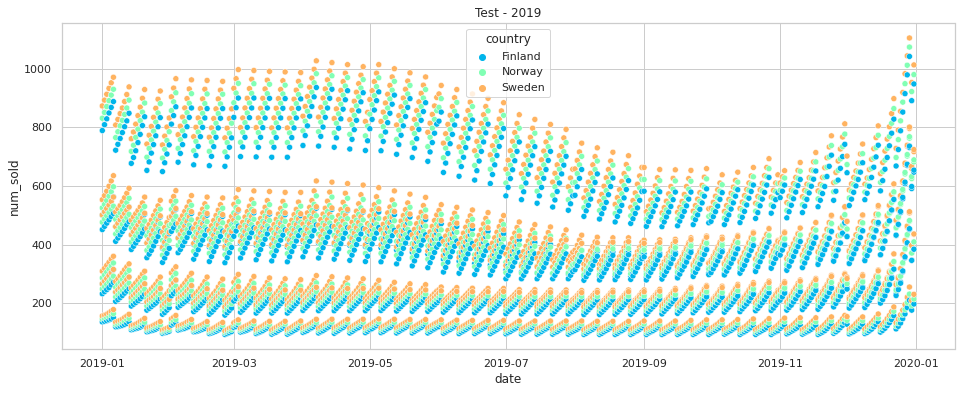

In [28]:
f, ax1 = plt.subplots(1, 1, figsize=(16, 6))

g1 = sns.scatterplot(x="date", y="num_sold", palette="rainbow", hue='country', data=test[test.date.dt.year==2019], ax=ax1)
g1.set_title("Test - 2019")

plt.show()

### ... To Be Continued